This notebook demonstrates prediction using pretrained model

### Importing modules

In [1]:
import pickle
import numpy as np
from src.loader import ModelLoader
from src.postprocessor import invert_scale_N_feature, calculate_rmse
import matplotlib.pyplot as plt

### Set up

Let's specify $ticker$ and $version$ assuming that the data version and model version are the same.
<br> We can always get a fresh set of data and train model using that as shown in $0.1.ModelTrainingWalk-through.ipynb$

In [2]:
ticker = 'QQEW'
version = 0
rolling_window = 20
forecast_horizon = 20

### Contruct model name

Without explicitly specifying model name, we can $construct\;model\;name$ using syntax.
> Syntax: TICKER_MODELFAMILY_RollingWindow_ForecastHorizon<br>
> Example: QQEW_LSTM_RW20_FH20_V2

In [3]:
basename = '{}_LSTM_RW{}_FH{}_V{}'.format(ticker, rolling_window, forecast_horizon, version)
print('basename =>', basename)

basename => QQEW_LSTM_RW20_FH20_V0


> The same basename will be used to read model training history

### Get the dataset

We have saved all the data in pickle file before training model.<br>
The filename schema remains similar.<br>
Let's read that.

In [4]:
filename = 'data/{}_PREPROCESSED_V{}.pickle'.format(ticker, version)
print('loading dataset from =>', filename)

with open(filename, 'rb') as f:
    dataset = pickle.load(f)
    print('dataset loaded')

loading dataset from => data/QQEW_PREPROCESSED_V0.pickle
dataset loaded


The dataset object is a python dict. Let's see the keys.

In [5]:
dataset.keys()

dict_keys(['splits', 'normalised_train', 'normalised_test', 'training_set', 'test_set'])

From dataset, we need the followings:<br>
> splits:<br>
> > we stored df_predict here<br>

> normalized_test:<br>
> > we stored scalers of test set here<br>

> test_set:<br>
> > we stored features and labels for testing here

Dataset is a nested dict. Let's access inside the key.

In [6]:
for key in dataset.keys():
    print(key, '--' ,dataset[key].keys())

splits -- dict_keys(['df_train', 'df_test', 'df_predict'])
normalised_train -- dict_keys(['normalised_data_py_list', 'scalers'])
normalised_test -- dict_keys(['normalised_data_py_list', 'scalers'])
training_set -- dict_keys(['normalised_data_np_array', 'features', 'labels'])
test_set -- dict_keys(['normalised_data_np_array', 'features', 'labels'])


### Load Model
Now, we can instantiate $ModelLoader$ class and load the model using $read\_model\_local$ method.

In [7]:
model = ModelLoader()

We have tiny docstring for help text.<br>
> Docstrings are not complete at this moment.

In [8]:
help(model.read_model_local)

Help on method read_model_local in module src.loader:

read_model_local(basename=None) method of src.loader.ModelLoader instance
    reads model specified by basename from /model directory of project root



Read the model!

In [9]:
model.read_model_local(basename=basename)

Loading model from model/QQEW_LSTM_RW20_FH20_V0.h5


Model can be accessed in ModelLoader attribute as $model.model$

Let's read model training history as dict object. It can be accessed as $training\_history$ attribute of $ModelLoader$ class.

In [10]:
model.read_training_history(basename=basename)
model.training_history.keys()

dict_keys(['loss', 'val_loss', 'lr'])

In $training\_history$,<br>
> $loss$ stands for loss in training set<br>
> $val\_loss$ stands for loss in validation set

We have used test_set as validation set during model training.<br>
We will use prediction set to test the model's final accuracy.<br>
>> We are having notation assignment problem here.

### Plot
Let's plot loss in training set and loss in validation set.

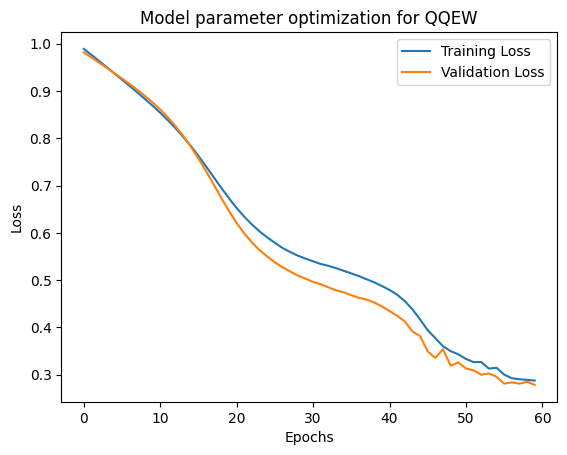

In [11]:
plt.plot(model.training_history['loss'], label='Training Loss')
plt.plot(model.training_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
leg = plt.legend(loc='upper right')
plt.title('Model parameter optimization for QQEW')
plt.show()

### Calculated Error (RMSE) in test set

In [12]:
# # This cell is to figure out keys
# for key in dataset.keys():
#     print(key, '--' ,dataset[key].keys())

In [13]:
# This cell is to check test set shape
print('test_set => normalised_data_np_array => shape => ', dataset['test_set']['normalised_data_np_array'].shape)
print('test_set => features => shape => ', dataset['test_set']['features'].shape)

test_set => normalised_data_np_array => shape =>  (1269, 40, 19)
test_set => features => shape =>  (1269, 20, 18)


Run predictions on test set

In [14]:
predictions = model.model.predict(dataset['test_set']['features'])

40/40 [==============================] - 5s 114ms/step


In [15]:
# # check more shapes
# print(len(dataset['normalised_test']['scalers']))
# print(dataset['test_set']['normalized_data_np_array'].shape)
# print(dataset['test_set']['labels'].squeeze().shape)
# print(predictions.squeeze().shape)

RMSE in USD

In [16]:
rmse_in_usd = calculate_rmse(
    scalers=dataset['normalised_test']['scalers'], 
    data=dataset['test_set']['normalised_data_np_array'], 
    labels=dataset['test_set']['labels'].squeeze(), 
    predicts=predictions.squeeze(), splitname='test')

The avearge root mse on test data is: 1.29


In [17]:
# rmse_in_usd

### Visualize last sample from test set

In [18]:
idx = len(dataset['normalised_test']['scalers']) - 1 
# what the date for last sample? 
# TODO: needs to implement a function to find date using prediction set

[inv_true, inv_pred] = invert_scale_N_feature(
    scaler=dataset['normalised_test']['scalers'][idx], 
    data=dataset['test_set']['normalised_data_np_array'][idx], 
    prediction=predictions.squeeze()[idx]
)

Plot prediction results in test set

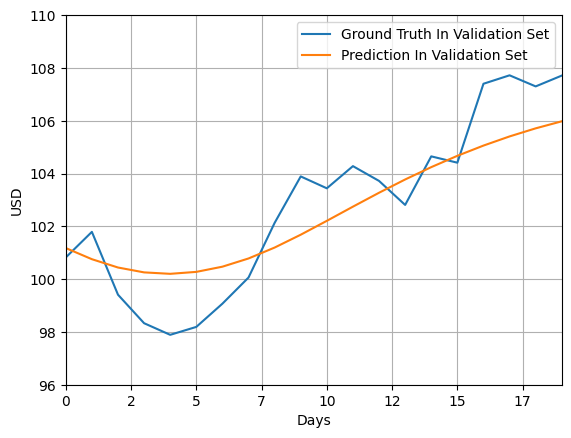

In [19]:
plt.plot(inv_true[-rolling_window:], label='Ground Truth In Validation Set')
plt.plot(inv_pred, label='Prediction In Validation Set')
plt.xlabel('Days')
plt.ylabel('USD')
leg = plt.legend(loc='upper right')
plt.yticks(ticks=plt.yticks()[0], labels=plt.yticks()[0].astype(int))
plt.xticks(ticks=plt.xticks()[0], labels=plt.xticks()[0].astype(int))
plt.xlim(xmin=0, xmax=19)  # this line
plt.grid()
plt.show()

### The following needs to be wrapped within a class for repeated use

### Predict using prediction dataset

In [20]:
# prediction dataset
dataset['splits']['df_predict']

,Adj Close,HL_PCT,PCT_change,Volume,MA_5,MA_20,MA_60,EMA_5,up_band,mid_band,low_band,ADX,MACD,RSI,ATR,MOM,WILLR,CCI,OBV
Date,,,,,,,,,,,,,,,,,,,
2023-11-20,109.029999,1.289424,1.075365,179600,107.832001,103.161501,104.579355,104.508000,109.075310,107.832001,106.588691,16.257619,0.808405,67.801064,1.479729,5.589996,-2.473008,123.175739,10456600.0
2023-11-21,108.360001,0.546242,-0.220993,50500,108.024001,103.490001,104.620254,105.127334,109.237298,108.024001,106.810703,16.825209,0.733538,64.454540,1.446891,4.080002,-12.828465,93.614549,10406100.0
2023-11-22,108.699997,0.782904,-0.027597,68800,108.220000,103.954500,104.633538,105.703334,109.488886,108.220000,106.951113,17.552810,0.663583,65.388154,1.419255,4.979996,-10.746292,96.026786,10474900.0
2023-11-24,109.000000,0.331126,0.183821,34700,108.559999,104.488000,104.640839,106.161334,109.538406,108.559999,107.581592,18.244031,0.596310,66.230980,1.345023,6.190002,-6.491470,84.952810,10509600.0
2023-11-27,108.720001,0.617510,-0.137780,53700,108.762000,105.029500,104.644638,106.483334,109.248357,108.762000,108.275642,18.800600,0.495871,64.648683,1.296807,4.070000,-12.658175,72.870241,10455900.0
2023-11-28,108.889999,0.626902,0.193227,79700,108.734000,105.564500,104.645114,106.846667,109.168805,108.734000,108.299194,19.315225,0.407496,65.192401,1.252749,4.479996,-16.562478,68.749304,10535600.0
2023-11-29,109.529999,0.923051,-0.036507,184900,108.967999,106.087500,104.664077,107.196667,109.572171,108.967999,108.363827,20.120595,0.360382,67.235510,1.273267,2.129997,-25.210129,99.768273,10720500.0
2023-11-30,109.610001,0.973994,-0.245720,167200,109.150000,106.565000,104.687037,107.589334,109.860492,109.150000,108.439508,20.604605,0.305040,67.492376,1.258034,1.889999,-22.969181,82.629837,10887700.0
2023-12-01,110.779999,1.530564,1.261423,105100,109.506000,106.997500,104.741810,108.120667,110.956990,109.506000,108.055010,21.281476,0.316307,71.065076,1.287460,3.479996,-0.000000,124.293630,10992800.0


In [21]:
first_date = dataset['splits']['df_predict'].index[0].date().strftime('%b-%d-%Y')
last_date = dataset['splits']['df_predict'].index[-1].date().strftime('%b-%d-%Y')
print('from {} to {}'.format(first_date, last_date))

from Nov-20-2023 to Dec-18-2023


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Scaling data for prediction

In [23]:
scaler.fit(dataset['splits']['df_predict'])

# scaling data
ndata = scaler.transform(dataset['splits']['df_predict'])
ndata_arr = np.array([ndata])
ndata_arr.shape

(1, 20, 19)

Isolating features and label from scaled data

In [24]:
ndata_arr_feature = ndata_arr[:, :, 1:]
ndata_arr_label = ndata_arr[:,:,:0] # This is not required since the future is unknown

In [25]:
# ndata_arr_feature.shape

Predicting future price

In [26]:
forecast = model.model.predict(ndata_arr_feature)

1/1 [==============================] - 0s 22ms/step


In [27]:
forecast.shape

(1, 20, 1)

> Inversing scale: normalised data to USD

In [28]:
[_, inv_pred_forecast] = invert_scale_N_feature(
    scaler=scaler, 
    data=ndata_arr[0], 
    prediction=forecast.squeeze()
) # we do not have any true inverse here. TODO: Implement new version

prepare date for axis labeling

In [29]:
# TODO: Needs to implement calender
# dates = [ date.date().isoformat() for date in dataset['splits']['df_predict'].index.tolist()]
# # dates

In [30]:
# print(inv_true_forecast.shape)
# print(inv_pred_forecast.shape)

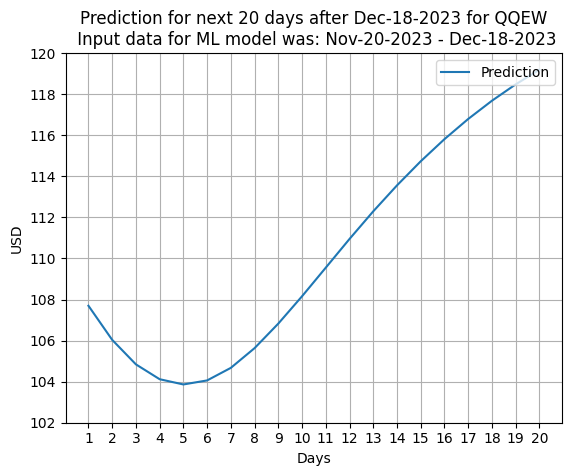

In [31]:
plt.plot(inv_pred_forecast, label='Prediction')
plt.xlabel('Days')
plt.ylabel('USD')
leg = plt.legend(loc='upper right')
plt.yticks(ticks=plt.yticks()[0], labels=plt.yticks()[0].astype(int))
# plt.xticks(ticks=list(range(20)), labels=dates, rotation = 90) # TODO: Needs to implement calender
plt.xticks(np.arange(len(inv_pred_forecast)), np.arange(1, len(inv_pred_forecast)+1))
# plt.title("Prediction for QQEW (Oct 20, 2023 - Nov 16, 2023)")
plt.grid()
plt.title('Prediction for next 20 days after {} for QQEW\n Input data for ML model was: {} - {}'.format(last_date, first_date, last_date))
plt.show()

Will be updated soon